# Discrete Wavelet Transform and scalograms
In this notebook, the discrete wavelet transform will be applied to a sample signals from the Physionet gaitndd dataset. Then, a visual representation of the coefficients yielded by the DWT (the scalogram) will be built.

A key factor of the Wavelet transform, as opposed to the Short Time Fourier Transform is that it does not need to sacrifice time resolution to have good frequency resolution (or viceversa).

The __[PyWavelets](https://pywavelets.readthedocs.io/en/latest/)__ package will be used.

In [3]:
import os
import random
import numpy as np
import scipy.signal as sgn
import matplotlib.pyplot as plt
import pywt

from matplotlib.colors import Normalize

%matplotlib inline

In [5]:
# define directories
rootdir = os.pardir
in_dir = os.path.join(rootdir, 'data/interim/normalized-signals')

# take an example record from the dataset
# signal = np.load(os.path.join(in_dir, 'hunt5_let_8.npy'))
filename = random.choice(os.listdir(in_dir))
signal = np.load(os.path.join(in_dir, filename))

## Discrete Wavelet Transform

First let's plot the loaded normalized signal segment:

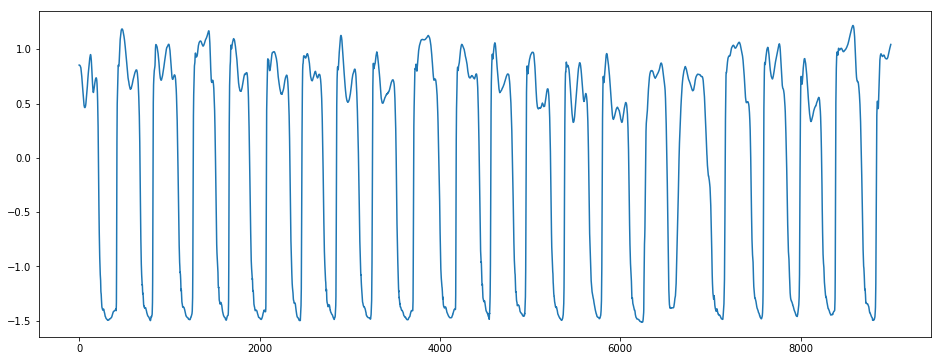

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
ax.plot(signal)

Now let's compute the Discrete Wavelet Transform.

The DWT functions as a tree of low-pass and high pass filters, as the following image shows:

![DWT filterbank](../img/filterbank_DWT.png)


The signal is split into a low-pass channel and a high-pass channel. Then the low-pass channel can be recursively split. The computed coefficients correspond to the Continuous Wavelet Transform coefficients over a dyadic scale (the bandwidth increases by 2 at every each level). More info on the Discrete Wavelet Transform can be found in this series of Matlab Tech Talks __[videos](https://www.youtube.com/watch?v=F7Lg-nFYooU&t=195s)__.

Signals extracted from the filterbank at higher iteration levels contain increasingly longer time-scale activity corresponding to lower frequencies, while those extracted from lower levels contain shorter time-scale activity corresponding to higher frequencies.

Using the __[wavedec function](https://pywavelets.readthedocs.io/en/latest/ref/dwt-discrete-wavelet-transform.html#multilevel-decomposition-using-wavedec)__ from the PyWavelets package, the wavelet transform coefficients can be computed.

There are many families of wavelets. In this case, we will use the ```symlet6``` wavelet, for example, with 6 levels of decomposition.

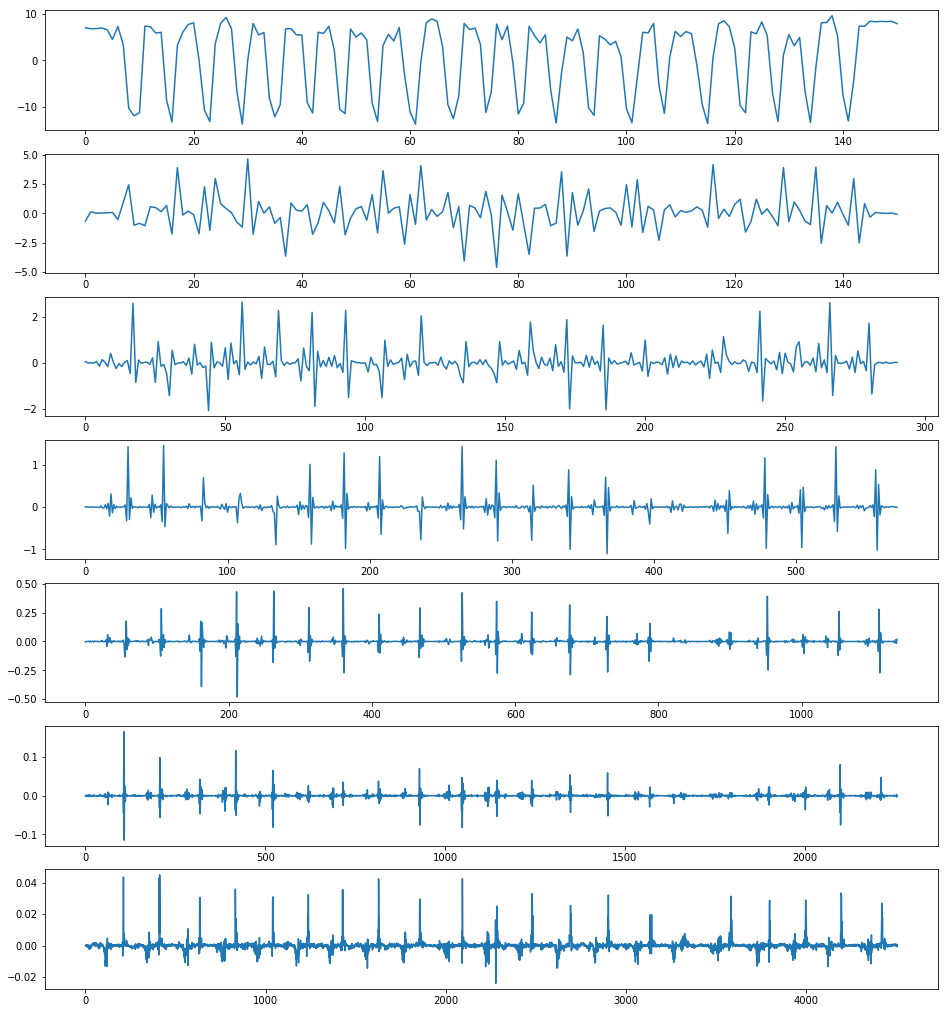

In [24]:
tree = pywt.wavedec(signal, 'sym6', level=6)

fig, axes = plt.subplots(len(tree), 1, figsize=(16, 18))
for i, coefs in enumerate(tree):
    axes[i].plot(coefs)

If we take a look at the shape of each of the arrays returned by the previous function we can see that the "granularity" increases from the first array to the following ones.

In [19]:
for c in tree:
    print(c.shape)

(151,)
(151,)
(291,)
(572,)
(1134,)
(2258,)
(4505,)


## Plot scalogram from Discrete Wavelet Transform
We can take the previous coefficients and plot a spectrogram-like image.

The following function is inspired by this __[post](https://stackoverflow.com/questions/16482166/basic-plotting-of-wavelet-analysis-output-in-matplotlib)__. Each level is scaled according to the frequency and time range that it spans.

In [25]:
def plot_full_scalogram(data):
    bottom = 0

    vmin = min(map(lambda x: min(abs(x)), data))
    vmax = max(map(lambda x: max(abs(x)), data))
    
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes()
    ax.set_autoscale_on(False) 
    
    for row in range(0, len(data)):
        scale = 2.0 ** (row - len(data))

        plt.imshow(
            np.asarray([abs(data[row])]),
            interpolation = 'nearest',
            vmin = vmin,
            vmax = vmax,
            extent = [0, 1, bottom, bottom + scale])

        bottom += scale

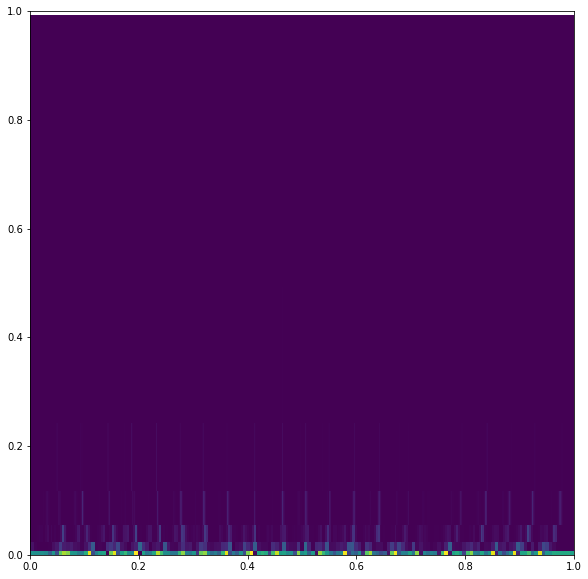

In [26]:
plot_full_scalogram(tree)

### Keeping only some levels
As can be seen, only the levels corresponding to low frequency and long time-scale changes have significant content. Thus, only the first 3 or 4 levels can be kept and plotted. The following function does exactly that and scales the resulting image accordingly.

In [27]:
def plot_scalogram(tree, levels=None):
    if levels:
        tree = tree[:levels]
        
    bottom = 0

    vmin = min(map(lambda x: min(abs(x)), tree))
    vmax = max(map(lambda x: max(abs(x)), tree))

    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes()
    ax.set_autoscale_on(False)
    
    for i in range(0, len(tree)):
        scale = 2.0 ** (i - len(tree))
        plt.imshow(
            np.asarray([abs(tree[i])]),
            interpolation = 'nearest',
            vmin=vmin,
            vmax=vmax,
            extent = [0, 1, bottom, bottom + scale])
        
        bottom += scale
    
    ax.set_ylim((0, bottom))
    
    return None

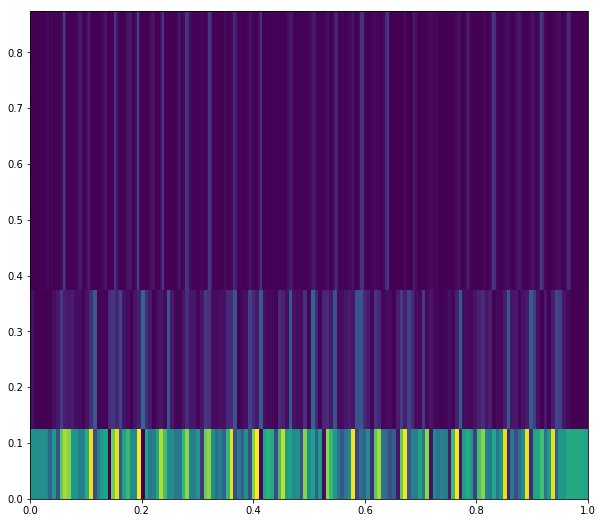

In [28]:
plot_scalogram(tree, 3)